In [35]:
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib as mpl
from matplotlib import pyplot as plt
from statistics import median
import os

fp = 'H:\\My Drive\\PROJECTS\\PSI 2022-2025\\XRF fundamentals vs. MVA'

### Sensitivity

#### For Beam 1 + Beam 2

In [2]:
df = pd.read_csv(fp+'\\misc\\duplicate_spectra_list.csv')
# select '18 samples
df = df[df.spectrum>=1800000000].reset_index(drop=True)

In [4]:
# get spectrum/sample pkey match from predictions file
key = pd.read_csv('Z:\\data_pXRF\\Olympus_instrument_predictions.csv')
df = key[['spectrum_number','pkey']].merge(df, how='right', left_on='spectrum_number', right_on='spectrum').drop(columns='spectrum_number')

# those with only one spectrum number would not have both filters, so remove them
temp = df.groupby('pkey', as_index=False).size().sort_values('size')
to_remove = temp[temp['size']==1]['pkey'].values
df = df[~df.pkey.isin(to_remove)].reset_index(drop=True)

In [ ]:
folder='Z:\\data_pXRF\\olympus_17_csv'

pkey_list = []
spectra_list = []
for p in tqdm(df.pkey.unique()):
    temp = df[df.pkey==p].copy().sort_values('filter')
    spectra = list(temp.spectrum.values)
    
    new_spectrum = []
    info = {
        '1':[],
        '2':[]
    }
    for spectrum in spectra:
        csv = pd.read_csv(f'{folder}\\{spectrum}.csv')
        
        beam = csv.loc['Beam','Olympus DELTA Premium Spectrum']
        res = csv.loc['eV per channel','Olympus DELTA Premium Spectrum']
        info[beam].append(res)
        
        s = csv['Olympus DELTA Premium Spectrum'][5:].values
        new_spectrum.append(s)
        
    for key in ['1','2']:
        if len(set(info[key])) > 1:
            print(f'Beam {key} does not have the same resolutions: {info[key]}')
            continue
            
    pkey_list.append(p)
    spectra_list.append(new_spectrum)

  0%|          | 0/315 [00:00<?, ?it/s]

Might be an issue if not resampled the same

In [ ]:
pd.DataFrame(spectra_list, columns=pkey_list)

#### For Beam 1, Beam 2

Calculations for filter 1
['1984AA', 'C11MA159'] had more than 2 duplicates and were excluded
Median sensitivity: 49.8
Mean sensitivity: 74.6


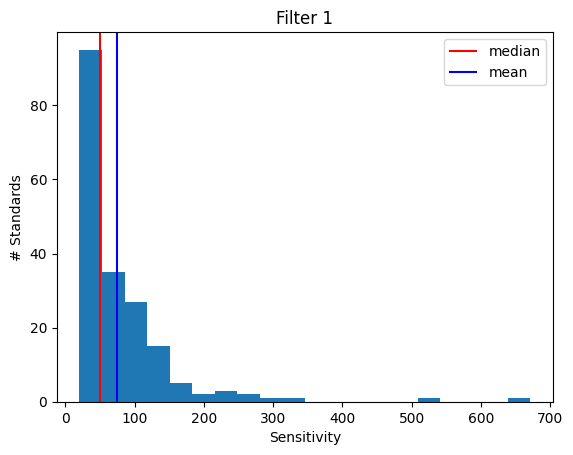

Calculations for filter 2
['1984AA', 'C11MA159'] had more than 2 duplicates and were excluded
Median sensitivity: 148.9
Mean sensitivity: 281.1


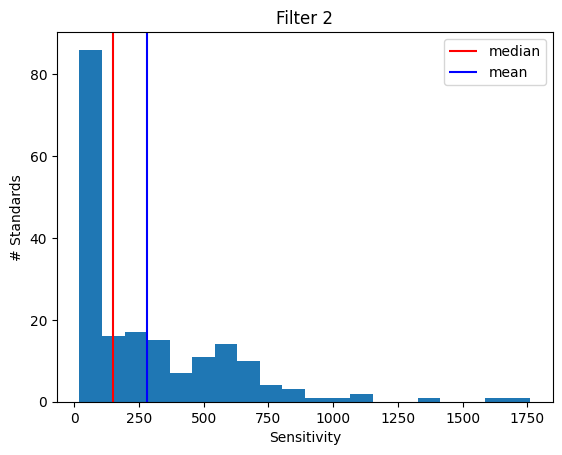

In [8]:
folder = "Z:\\data_pXRF\\olympus_17_csv\\"

med_list = []
mean_list = []

for filt in [1,2]:
    
    print("Calculations for filter", str(filt))
    
    sens_list = []
    err_list = []
    
    # filter by filter type
    temp_df = df[df['filter']==filt]
    
    # get list of samples
    samples = temp_df['sample'].unique()
    
    # for each sample:
    for sample in samples:
        
        temp = temp_df[temp_df['sample']==sample]
        
        # get spectra names
        spectra = temp.spectrum.unique()
        if len(spectra) > 2:
            err_list.append(sample)
            continue

        # first spectrum
        spec1 = str(spectra[0])
        temp1 = pd.read_csv(folder+spec1+'.csv', skiprows=20)
        temp1 = temp1.set_index('Channel #')
        temp1 = temp1.iloc[1:2048, :] # remove first and last rows b/c where stuff gets weird
        temp1['Intensity'] = temp1['Intensity'].astype(int)
        
        # second spectrum
        spec2 = str(spectra[1])
        temp2 = pd.read_csv(folder+spec2+'.csv', skiprows=20)
        temp2 = temp2.set_index('Channel #')
        temp2 = temp2.iloc[1:2048, :]
        temp2['Intensity'] = temp2['Intensity'].astype(int)
        
        # merge and calculate sensitivity
        temp = pd.merge(temp1, temp2, left_index=True, right_index=True)
        temp = temp.T
        sens = temp.astype('float').std(axis=0).mean()
        sens_list.append(sens)
        
    print(err_list, "had more than 2 duplicates and were excluded")
    median_sens = round(median(sens_list),9)
    print("Median sensitivity:", round(median_sens,1))
    med_list.append(median_sens)
    
    mean_sens = sum(sens_list) / len(sens_list)
    print("Mean sensitivity:", round(mean_sens,1))
    mean_list.append(mean_sens)
    
    # compare median to mean
    med_c = 'red'
    mean_c = 'blue'

    plt.hist(sens_list, bins=20)
    plt.ylabel("# Standards")
    plt.xlabel("Sensitivity")
    y_bot, y_top = plt.ylim()
    plt.vlines(x=median_sens,
               ymin = 0,
               ymax = y_top,
               colors=med_c,
               label='median')
    plt.vlines(x=mean_sens,
               ymin = 0,
               ymax = y_top,
               colors=mean_c,
               label='mean')
    plt.title("Filter "+str(filt))
    plt.legend()
    plt.ylim((0,y_top))
    plt.show()
    
results = pd.DataFrame({
    'filter' : [1,2],
    'median_sens' : med_list,
    'mean_sens' : mean_list
})

results.to_csv(fp+'\\sensitivities.csv', index=False)